## Bag of Words Classification

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import nltk
import pickle
from contextlib import contextmanager
import copy
import os
import re
import string
import time
import keras
import warnings
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [2]:
@contextmanager
def timer(msg):
    t0 = time.time()
    print(f'[{msg}] start.')
    yield
    elapsed_time = time.time() - t0
    print(f'[{msg}] done in {elapsed_time / 60:.2f} min.')

In [3]:
# Create a function to calculate the error metrics, since we'll be doing this several times
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
        
    Accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),2)
    Precision = round((true_pos) / (true_pos + false_pos),2)
    Recall = round((true_pos) / (true_pos + false_neg),2)
    F1 = round(2 * (Precision * Recall) / (Precision + Recall),2)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predicted)
    AUC = round(auc(false_positive_rate, true_positive_rate),2)
    
    cm_results = [Accuracy, Precision, Recall, F1, AUC]
    return cm_results

In [4]:
data = pd.read_csv('cleaned_short_simple.csv')

In [5]:
any(data.comment_text.isnull())

True

In [6]:
data.shape

(235087, 2)

In [7]:
data = data.dropna()

In [8]:
data.shape

(234723, 2)

In [9]:
x = data.comment_text
y = data.y

In [10]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

In [11]:
# Balance train set
x_balance, y_balance = RandomOverSampler().fit_sample(pd.DataFrame(x_train), y_train)

In [12]:
x_balance = x_balance.tolist()
x_balance = [x for [x] in x_balance]
x_balance = pd.DataFrame(x_balance)

In [13]:
x_balance = x_balance[0]

## Count Vec Single / Bigram

In [14]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words='english', binary=True)

x_train_cv1 = cv1.fit_transform(x_balance)
x_test_cv1  = cv1.transform(x_test)

In [15]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english')

x_train_cv2 = cv2.fit_transform(x_balance)
x_test_cv2  = cv2.transform(x_test)

In [16]:
# Save Probabilities for all models
probabilities = {}

In [17]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
# Train the first model
lr.fit(x_train_cv1, y_balance)
y_pred_cv1 = lr.predict(x_test_cv1)
y_prob_log1 = lr.predict_proba(x_test_cv1)
probabilities['log_reg'] = y_prob_log1
# Train the second model
lr.fit(x_train_cv2, y_balance)
y_pred_cv2 = lr.predict(x_test_cv2)
y_prob_log2 = lr.predict_proba(x_test_cv2)
probabilities['log_reg_bigram'] = y_prob_log2

/Users/kelvin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


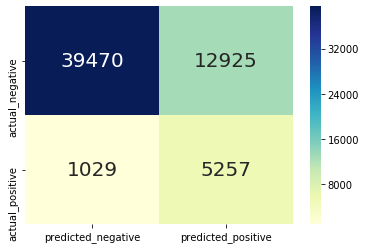

In [31]:
y_pred_cv1_log = (probabilities['log_reg'][:,1] > .17).astype(int)
cm1 = conf_matrix(y_test, y_pred_cv1_log)

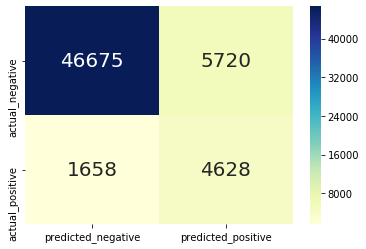

In [19]:
# The heat map for the second logistic regression model
y_pred_cv2_log = (probabilities['log_reg_bigram'][:,1] > .17).astype(int)
cm2 = conf_matrix(y_test, y_pred_cv2_log)

In [20]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(x_train_cv1, y_balance)

y_pred_cv1_nb = bnb.predict(x_test_cv1)
y_pred_nb_probs = bnb.predict_proba(x_test_cv1)
probabilities['BernoulliNB'] = y_pred_nb_probs

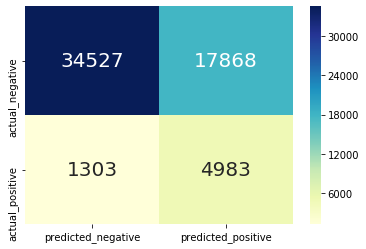

In [21]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)

In [22]:
model = XGBClassifier()
model.fit(x_train_cv1, y_balance)
y_pre_cv1_xgb = model.predict(x_test_cv1)
xgb_prob = model.predict_proba(x_test_cv1)
probabilities['XGB'] = xgb_prob

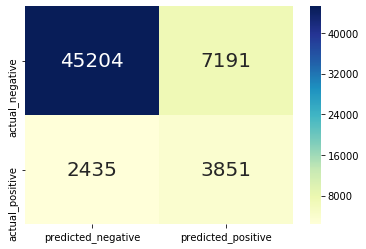

In [23]:
cm4 = conf_matrix(y_test, y_pre_cv1_xgb)

In [24]:
deep_model = keras.Sequential([
    keras.layers.Dense(units=50, input_shape=(92293, ), name="hidden_layer"),
    keras.layers.Activation("relu", name="1_activation"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, name="hidden_layer2"),
    keras.layers.Activation("relu", name="2_activation"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=1, name="output_layer"),
    keras.layers.Activation("sigmoid", name="sigmoid_activation"),   
])
deep_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
with timer('keras'):
    deep_model.fit(x_train_cv1, y_balance, epochs=3)

[keras] start.
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
314372/314372 [==============================] - 583s 2ms/step - loss: 0.3407 - binary_accuracy: 0.8600
Epoch 2/3
314372/314372 [==============================] - 596s 2ms/step - loss: 0.1952 - binary_accuracy: 0.9252
Epoch 3/3
314372/314372 [==============================] - 640s 2ms/step - loss: 0.1451 - binary_accuracy: 0.9454
[keras] done in 30.35 min.


In [26]:
pred_nn = deep_model.predict(x_test_cv1)

In [27]:
pred_nn_probs = deep_model.predict_proba(x_test_cv1)

In [28]:
probabilities['NN_2layers'] = pred_nn_probs

In [29]:
pred_nn_ = np.where(pred_nn >= 0.1, 1, 0)

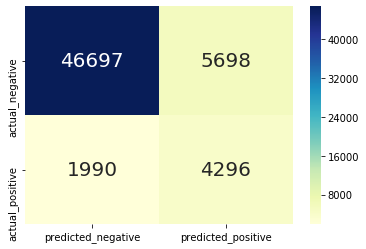

In [30]:
cm5 = conf_matrix(y_test, pred_nn_)

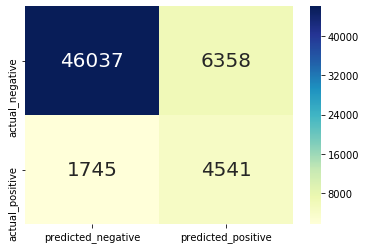

In [36]:
y_pred_cv1_log = (probabilities['log_reg'][:,1] > .40).astype(int)
cm1 = conf_matrix(y_test, y_pred_cv1_log)

In [37]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm3, cm4, cm5, cm1, cm2)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']])
results_nb.columns = ['BernoulliNB', 'XGB', 'NN_2layer', 'LogReg_bi', 'LogReg_bi']
results_nb

,BernoulliNB,XGB,NN_2layer,LogReg_bi,LogReg_bi
Accuracy,0.67,0.84,0.87,0.86,0.87
Precision,0.22,0.35,0.43,0.42,0.45
Recall,0.79,0.61,0.68,0.72,0.74
F1 Score,0.34,0.44,0.53,0.53,0.56
AUC,0.73,0.74,0.79,0.80,0.81


In [34]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

In [35]:
cnn_probs = pd.read_csv('probs_cnn.csv')

probabilities['CNN_100Glove'] = np.array(cnn_probs['Glove100'])

probabilities['CNN_300Glove'] = np.array(cnn_probs['Glove300'])

FileNotFoundError: [Errno 2] File b'probs_cnn.csv' does not exist: b'probs_cnn.csv'

In [323]:
probs_names = ['CNN_300Glove', 'log_reg_bigram', 'CNN_100Glove', 'log_reg', 'NN_2layers', 'XGB', 'BernoulliNB']

In [273]:
#new_probs = probabilities.pop('log_reg', None)

In [324]:
ordered_probs = {}

In [325]:
ordered_probs['CNN_300Glove'] = probabilities['CNN_300Glove']
ordered_probs['CNN_100Glove'] = probabilities['CNN_100Glove']
ordered_probs['log_reg_bigram'] = probabilities['log_reg_bigram']
ordered_probs['NN_2layers'] = probabilities['NN_2layers']
ordered_probs['XGB'] = probabilities['XGB']
ordered_probs['BernoulliNB'] = probabilities['BernoulliNB']

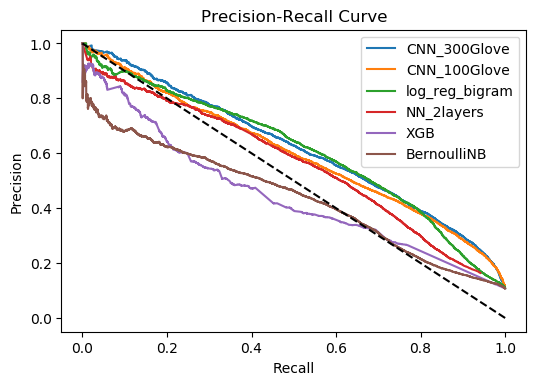

In [326]:
plt.figure(dpi=100)
for model, prob in ordered_probs.items():
    if model in ['NN_2layers', 'CNN_100Glove', 'CNN_300Glove']:
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, prob)
    else:
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, prob[:, 1])
    plt.plot(recall_curve[1:], precision_curve[1:], label='precision')
    plt.legend(ordered_probs.keys())
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
plt.plot([1, 0], [0, 1], c='black', ls='--')

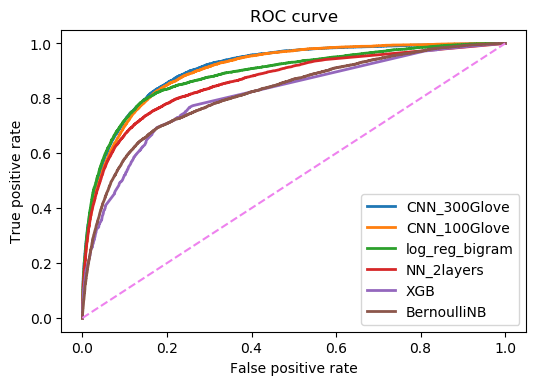

In [327]:
plt.figure(dpi=100)
for model, prob in ordered_probs.items():
    if model in ['NN_2layers', 'CNN_100Glove', 'CNN_300Glove']:
        fpr, tpr, thresholds = roc_curve(y_test, prob)
    else:
        fpr, tpr, thresholds = roc_curve(y_test, prob[:, 1])
    plt.plot(fpr, tpr, lw=2)
    plt.legend(ordered_probs.keys())
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve');
plt.plot([0, 1], [0, 1], c='violet', ls='--')

# CV 

In [26]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm1, cm2, cm3, cm4, cm5, cm6)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['LogReg1', 'LogReg2', 'NB1-Multi', 'NB2-Multi', 'NB1-Ber', 'NB2-Ber']
results_nb

,LogReg1,LogReg2,NB1-Multi,NB2-Multi,NB1-Ber,NB2-Ber
Accuracy,0.878,0.913,0.730,0.800,0.674,0.701
Precision,0.453,0.602,0.255,0.297,0.218,0.220
Recall,0.662,0.560,0.790,0.636,0.796,0.706
F1 Score,0.538,0.580,0.386,0.405,0.342,0.335


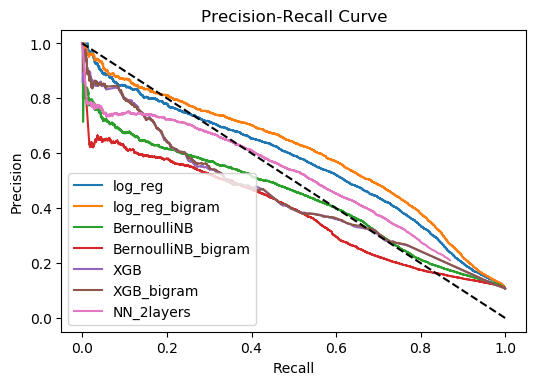

In [143]:
plt.figure(dpi=100)
for model, prob in probabilities.items():
    if model == 'NN_2layers':
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, prob)
    else:
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, prob[:, 1])
    plt.plot(recall_curve[1:], precision_curve[1:], label='precision')
    plt.legend(probabilities.keys())
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
plt.plot([1, 0], [0, 1], c='black', ls='--')

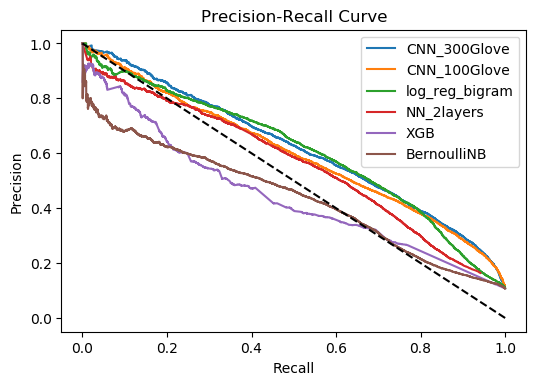

In [326]:
plt.figure(dpi=100)
for model, prob in ordered_probs.items():
    if model in ['NN_2layers', 'CNN_100Glove', 'CNN_300Glove']:
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, prob)
    else:
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, prob[:, 1])
    plt.plot(recall_curve[1:], precision_curve[1:], label='precision')
    plt.legend(ordered_probs.keys())
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
plt.plot([1, 0], [0, 1], c='black', ls='--')

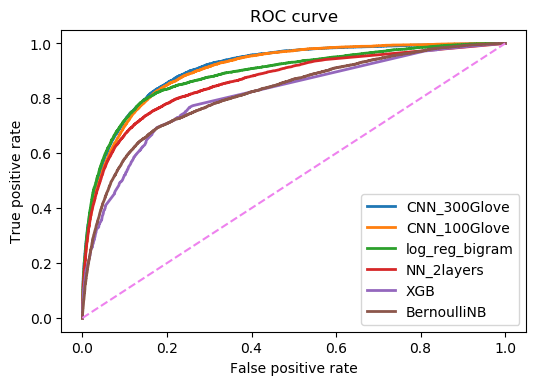

In [327]:
plt.figure(dpi=100)
for model, prob in ordered_probs.items():
    if model in ['NN_2layers', 'CNN_100Glove', 'CNN_300Glove']:
        fpr, tpr, thresholds = roc_curve(y_test, prob)
    else:
        fpr, tpr, thresholds = roc_curve(y_test, prob[:, 1])
    plt.plot(fpr, tpr, lw=2)
    plt.legend(ordered_probs.keys())
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve');
plt.plot([0, 1], [0, 1], c='violet', ls='--')